# TABLE STATIC ANALYSIS

This table is composed by 3 tables:

- <code>train_static_0_0</code>, <code>train_static_0_1</code> that are internal data frames of home credit.
- <code>train_tatic_cb_0</code> that is an external dataset.

We are mainly interested in the internal datasets since we will have to do a stable inference in a future and a not sure table cannot be a good predictor with this goal.

We will analyze this points:

- the columns of all dataframes
- how to merge them
- their NA meanings and how to fill them
- some plots

!!! From https://www.kaggle.com/competitions/home-credit-credit-risk-model-stability/discussion/476463 we can see that the person age must be taken from train_person_1 "birth_259D".

# 1. SETTINGS

In [1]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
dataPath = "../../data/"

We will import the target dataframe with the features definition in order to improve the graphics later. 

In [3]:
df_target = pd.read_parquet(dataPath + 'parquet_files/train/train_base.parquet')

In [4]:
df_feature = pd.read_csv(dataPath + 'feature_definitions.csv')
df_feature = df_feature.set_index('Variable')
df_feature.index.name = None

dict_feature = df_feature.to_dict()
dict_feature = dict_feature['Description']
dict_feature

{'actualdpd_943P': 'Days Past Due (DPD) of previous contract (actual).',
 'actualdpdtolerance_344P': 'DPD of client with tolerance.',
 'addres_district_368M': "District of the person's address.",
 'addres_role_871L': "Role of person's address.",
 'addres_zip_823M': 'Zip code of the address.',
 'amount_1115A': 'Credit amount of the active contract provided by the credit bureau.',
 'amount_416A': 'Deposit amount.',
 'amount_4527230A': 'Tax deductions amount tracked by the government registry.',
 'amount_4917619A': 'Tax deductions amount tracked by the government registry.',
 'amtdebitincoming_4809443A': 'Incoming debit card transactions amount.',
 'amtdebitoutgoing_4809440A': 'Outgoing debit card transactions amount.',
 'amtdepositbalance_4809441A': 'Deposit balance of client.',
 'amtdepositincoming_4809444A': "Amount of incoming deposits to client's account.",
 'amtdepositoutgoing_4809442A': "Amount of outgoing deposits from client's account.",
 'amtinstpaidbefduel24m_4187115A': 'Number

In [5]:
train_static_0_0 = pl.read_parquet(dataPath + "parquet_files/train/train_static_0_0.parquet")
train_static_0_1 = pl.read_parquet(dataPath + "parquet_files/train/train_static_0_1.parquet")
train_static_cb_1 = pl.read_parquet(dataPath + "parquet_files/train/train_static_cb_0.parquet")


# 2. STRUCTURE OF THE DATAFRAMES

Let's first see how the dataframe are made. 

In [6]:
train_static_0_0.shape

(1003757, 168)

In [7]:
train_static_0_1.shape

(522902, 168)

In [8]:
train_static_cb_1.shape

(1500476, 53)

It's quite clear that the esternal dataframe has a different structure. 

In this first analys as we have said we will only analyze the internal dataset. 

# 3. INTERNAL DATA SOURCE ANALYSIS

Let's first see if the internal datasources have the same columns.

In [9]:
columns_0_0 = list(train_static_0_0.columns)
columns_0_1 = list(train_static_0_1.columns)

columns_0_0.sort()
columns_0_1.sort()

columns_0_0 == columns_0_1

True

The two dataframe have the same columns but different rows.

Let's go in more details.

In [10]:
print("Number of case id in first dataframe: ", train_static_0_0["case_id"].n_unique())
print("The case id are unique in the first dataframe: ", train_static_0_0["case_id"].n_unique() == train_static_0_0.shape[0])


Number of case id in first dataframe:  1003757
The case id are unique in the first dataframe:  True


In [11]:
print("Number of case id in second dataframe: ", train_static_0_1["case_id"].n_unique())
print("The case id are unique in the second dataframe: ", train_static_0_1["case_id"].n_unique() == train_static_0_1.shape[0])


Number of case id in second dataframe:  522902
The case id are unique in the second dataframe:  True


So each case id in the dataframes is unique.

Let's see if the two dataframe have some case id in common.

In [12]:
set(train_static_0_1["case_id"].unique()).intersection(set(train_static_0_0["case_id"].unique()))

set()

**We can conclude that we have two perfectly separated dataframes with each one its case ids and with the same columns. We can concated them.**

In [13]:
train_static_internal = pl.concat(
    [
        train_static_0_0, 
        train_static_0_1,
    ],
    how="vertical_relaxed",
)

# 4. DEEPER ANALYSIS ON THE COMPLETE INTERNAL TABLE

Let's move to a deeper analysis on the entire dataframe.

Create the pandas representation in order to plot it.

In [14]:
train_static_internal_pd = train_static_internal.to_pandas()

## 4.1 NULL ANALYSIS

In [15]:
df_nulls = (train_static_internal.null_count() / train_static_internal.shape[0]).transpose(include_header=True).sort(by="column_0", descending=True).to_pandas()
df_nulls["perc_of_nulls"] = df_nulls.iloc[:, 1] 
df_nulls = df_nulls.drop("column_0", axis = 1)
df_nulls

,column,perc_of_nulls
0,clientscnt_136L,0.999727
1,lastrepayingdate_696D,0.998443
2,lastotherinc_902A,0.997998
3,lastotherlnsexpense_631A,0.997997
4,payvacationpostpone_4187118D,0.993889
...,...,...
163,numpmtchanneldd_318L,0.000000
164,numrejects9m_859L,0.000000
165,previouscontdistrict_112M,0.000000
166,sellerplacecnt_915L,0.000000


As we can see in case of a lot of null it seems this is a information. We have to understand how to deal with it. 

<Axes: >

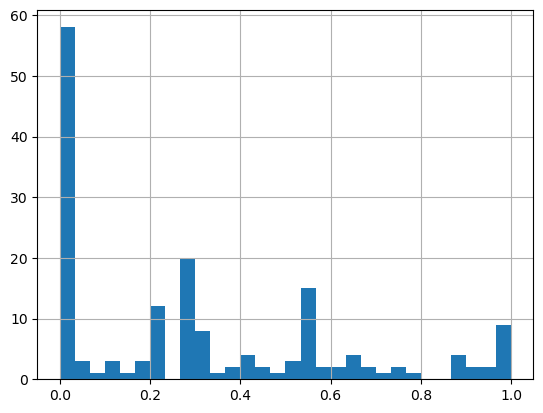

In [16]:
df_nulls["perc_of_nulls"].hist(bins=30)

In [18]:
df_nulls.loc[(df_nulls["perc_of_nulls"] < 0.8) & (df_nulls["perc_of_nulls"]>0.6)]

,column,perc_of_nulls
17,totinstallast1m_4525188A,0.769138
18,maxpmtlast3m_4525190A,0.739740
19,typesuite_864L,0.734614
20,bankacctype_710L,0.726835
21,maxlnamtstart6m_4525199A,0.676547
22,avgpmtlast12m_4525200A,0.672702
23,lastdelinqdate_224D,0.640598
24,dtlastpmtallstes_4499206D,0.640037
25,avgdbdtollast24m_4525197P,0.637226
26,mindbdtollast24m_4525191P,0.637226


It's seems in this case as well that the absence of the value is an information. 

## 4.2 ANALYSIS OF CATEGORICAL VS NUMERICAL 

We first want to split the numerical variable from the cathegorical ones.

In [27]:
features_num = list(train_static_internal_pd.select_dtypes('number'))
features_total = train_static_internal_pd.columns.tolist()
features_date = [el for el in features_total if el.endswith("D")]
features_cat = [el for el in features_total if el not in (features_num + features_date)]
features_num.remove('case_id')

In [29]:
features_date

['datefirstoffer_1144D',
 'datelastinstal40dpd_247D',
 'datelastunpaid_3546854D',
 'dtlastpmtallstes_4499206D',
 'firstclxcampaign_1125D',
 'firstdatedue_489D',
 'lastactivateddate_801D',
 'lastapplicationdate_877D',
 'lastapprdate_640D',
 'lastdelinqdate_224D',
 'lastrejectdate_50D',
 'lastrepayingdate_696D',
 'maxdpdinstldate_3546855D',
 'payvacationpostpone_4187118D',
 'validfrom_1069D']

In [28]:
for col in features_cat:
    print(f"  {col}")

  bankacctype_710L
  cardtype_51L
  credtype_322L
  disbursementtype_67L
  equalitydataagreement_891L
  equalityempfrom_62L
  inittransactioncode_186L
  isbidproduct_1095L
  isbidproductrequest_292L
  isdebitcard_729L
  lastapprcommoditycat_1041M
  lastapprcommoditytypec_5251766M
  lastcancelreason_561M
  lastrejectcommoditycat_161M
  lastrejectcommodtypec_5251769M
  lastrejectreason_759M
  lastrejectreasonclient_4145040M
  lastst_736L
  opencred_647L
  paytype1st_925L
  paytype_783L
  previouscontdistrict_112M
  twobodfilling_608L
  typesuite_864L


From the date column we can see that we will need to compute a difference between a reference time and the considered date. 

In [30]:
# aesthetics
default_color_1 = 'darkblue'
default_color_2 = 'darkgreen'
default_color_3 = 'darkred'

In [31]:
train_static_internal_pd = train_static_internal_pd.merge(df_target, on='case_id')

Let's see how much values are unique in the numerical and categorical variables.

In [33]:
for col in features_num:
    print(col, ": ", len(train_static_internal_pd[col].unique()))

actualdpdtolerance_344P :  171
amtinstpaidbefduel24m_4187115A :  610153
annuity_780A :  75325
annuitynextmonth_57A :  66203
applicationcnt_361L :  5
applications30d_658L :  25
applicationscnt_1086L :  125
applicationscnt_464L :  248
applicationscnt_629L :  90
applicationscnt_867L :  153
avgdbddpdlast24m_3658932P :  4525
avgdbddpdlast3m_4187120P :  3940
avgdbdtollast24m_4525197P :  4032
avgdpdtolclosure24_3658938P :  4314
avginstallast24m_3658937A :  92854
avglnamtstart24m_4525187A :  57040
avgmaxdpdlast9m_3716943P :  224
avgoutstandbalancel6m_4187114A :  559676
avgpmtlast12m_4525200A :  92821
clientscnt12m_3712952L :  89
clientscnt3m_3712950L :  79
clientscnt6m_3712949L :  89
clientscnt_100L :  20
clientscnt_1022L :  107
clientscnt_1071L :  11
clientscnt_1130L :  34
clientscnt_136L :  6
clientscnt_157L :  42
clientscnt_257L :  12
clientscnt_304L :  68
clientscnt_360L :  10
clientscnt_493L :  83
clientscnt_533L :  9
clientscnt_887L :  1037
clientscnt_946L :  22
cntincpaycont9m_3716944L 

In [32]:
date_columns = []
long_features_cat = []
short_features_cat = []
for col in features_cat:
    if 'date' in col or col.endswith("D"):
        date_columns.append(col)
        features_cat.remove(col)
    elif len(train_static_internal_pd[col].unique()) > 10:
        long_features_cat.append(col)
    elif len(train_static_internal_pd[col].unique()) <= 10:
        short_features_cat.append(col)
    else: 
        raise ValueError("Strange column: ", col)
        

In [34]:
for col in long_features_cat:
    print(col, ": ", len(train_static_internal_pd[col].unique()))

lastapprcommoditycat_1041M :  45
lastapprcommoditytypec_5251766M :  214
lastcancelreason_561M :  74
lastrejectcommoditycat_161M :  45
lastrejectcommodtypec_5251769M :  187
lastrejectreason_759M :  18
lastrejectreasonclient_4145040M :  14
lastst_736L :  12
previouscontdistrict_112M :  223


In [35]:
for col in short_features_cat:
    print(col, ": ", len(train_static_internal_pd[col].unique()))

bankacctype_710L :  2
cardtype_51L :  3
credtype_322L :  4
disbursementtype_67L :  4
equalitydataagreement_891L :  3
equalityempfrom_62L :  3
inittransactioncode_186L :  4
isbidproduct_1095L :  2
isbidproductrequest_292L :  3
isdebitcard_729L :  2
opencred_647L :  3
paytype1st_925L :  2
paytype_783L :  2
twobodfilling_608L :  3
typesuite_864L :  2


In [36]:
train_static_internal_pd["isdebitcard_729L"].unique()

array([None, False], dtype=object)

In [37]:
train_static_internal_pd["isbidproductrequest_292L"].unique()

array([None, False, True], dtype=object)

In [38]:
train_static_internal_pd["paytype_783L"].unique()

array(['OTHER', None], dtype=object)

In [39]:
train_static_internal_pd["typesuite_864L"].unique()

array([None, 'AL'], dtype=object)

In [40]:
train_static_internal_pd["bankacctype_710L"].unique()

array([None, 'CA'], dtype=object)

In [41]:
train_static_internal_pd["isbidproduct_1095L"].unique()

array([False,  True])

We can see a very big difference among the variable cardinality.

In [42]:
def plot_continuous(df, feature, txt):
    '''Plot a histogram and boxplot for the churned and retained distributions for the specified feature.'''
    df_func = df.copy()
    df_paid = df.loc[df["target"] == 1]
    df_default = df.loc[df["target"] == 0]
    
    df_func['target'] = df_func['target'].astype('category')
    fig, ax1 = plt.subplots()

    for df, label in zip([df_paid,df_default], [0, 1]): 
        sns.boxplot(data=df,
                     x=feature,
                     bins=30,
                     alpha=0.66,
                     edgecolor='firebrick',
                     label=label,
                     kde=False,
                     ax=ax1)
    ax1.legend()
    fig.text(.5, .005, txt, ha='center')
    plt.tight_layout();

In [43]:
def plot_categorical(df, feature, txt):
    '''For a categorical feature, plot a seaborn.countplot for the total counts of each category next to a barplot for the churn rate.'''
    fig, ax1 = plt.subplots()

    sns.countplot(x=feature,
                  hue='target',
                  data=df,
                  ax=ax1)
    ax1.set_ylabel('Count')
    ax1.legend(labels=['paid', 'default'])
    ax1.tick_params(axis='x', rotation=90)
    
    fig.text(.5, .005, txt, ha='center')
    plt.tight_layout();


bankacctype_710L
cardtype_51L
credtype_322L
disbursementtype_67L
equalitydataagreement_891L
equalityempfrom_62L
inittransactioncode_186L
isbidproduct_1095L
isbidproductrequest_292L
isdebitcard_729L
opencred_647L
paytype1st_925L
paytype_783L
twobodfilling_608L
typesuite_864L


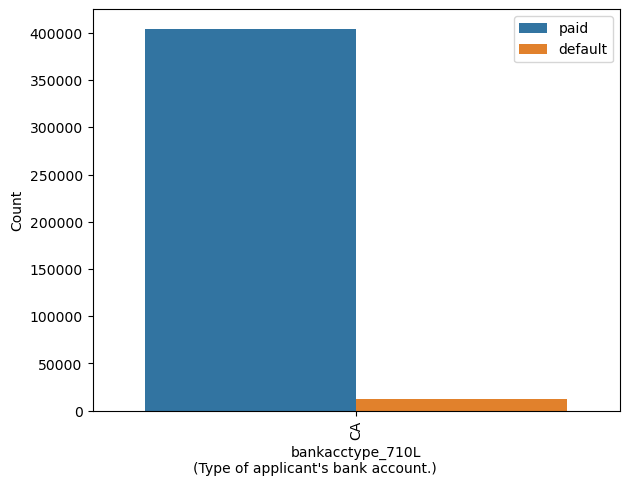

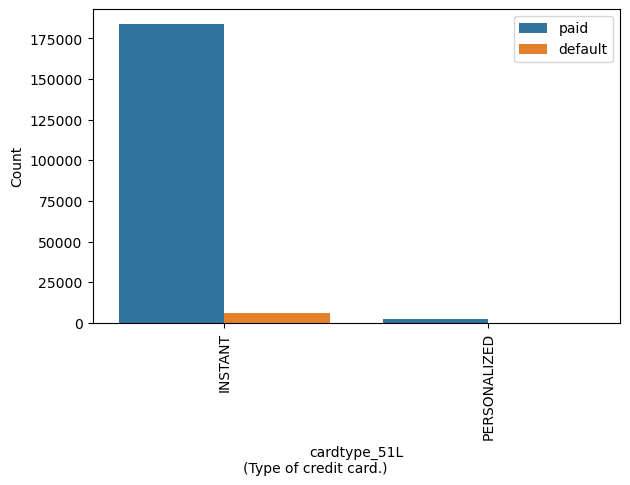

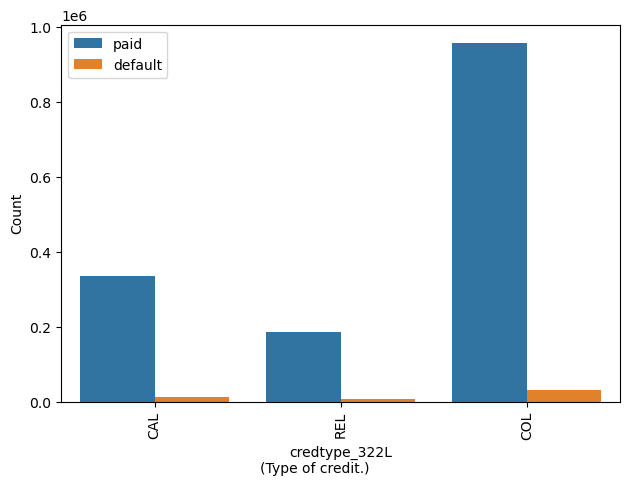

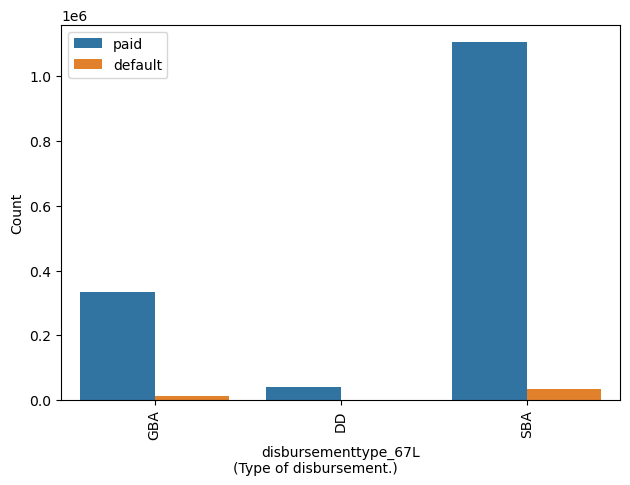

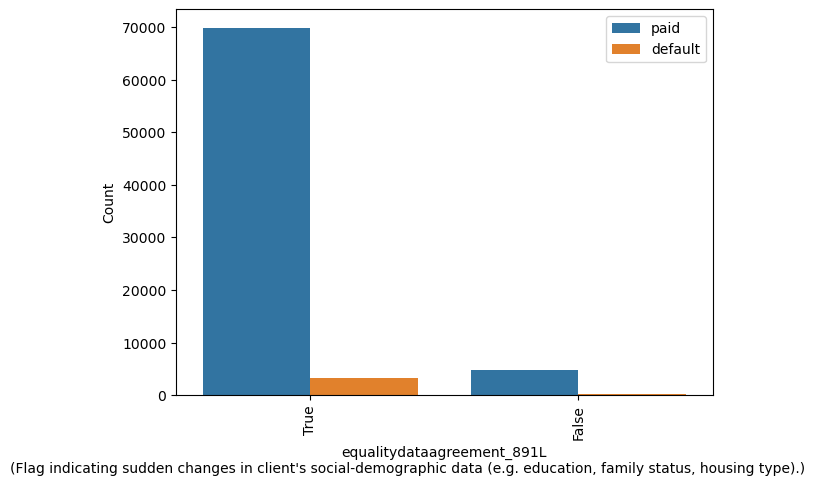

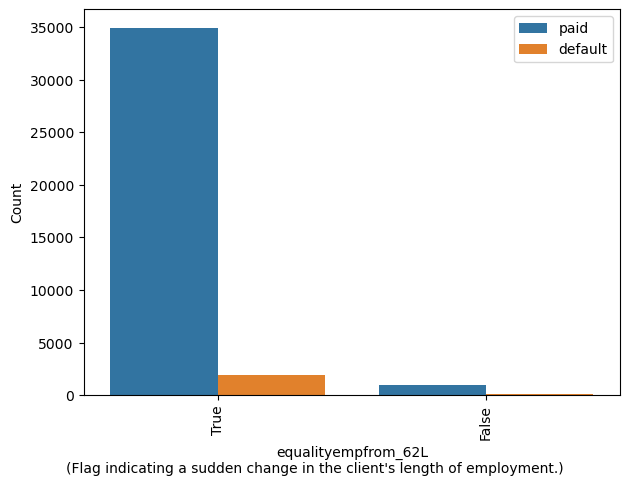

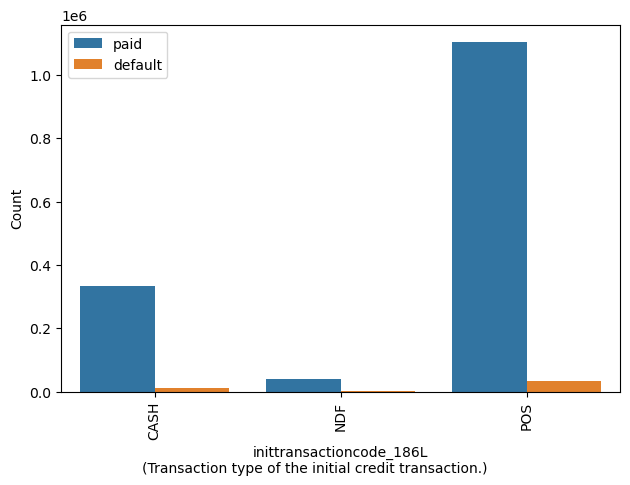

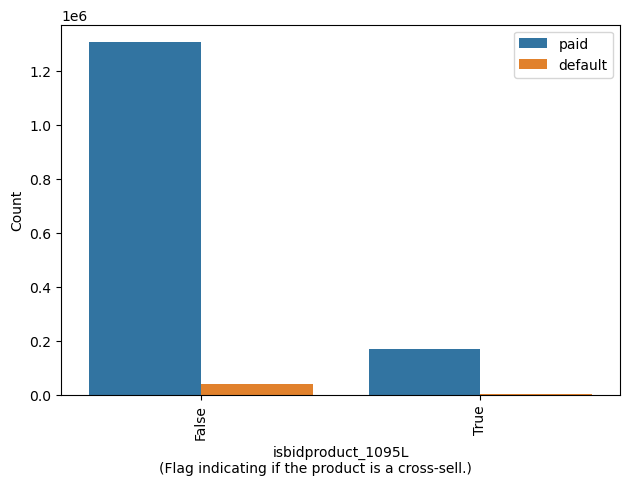

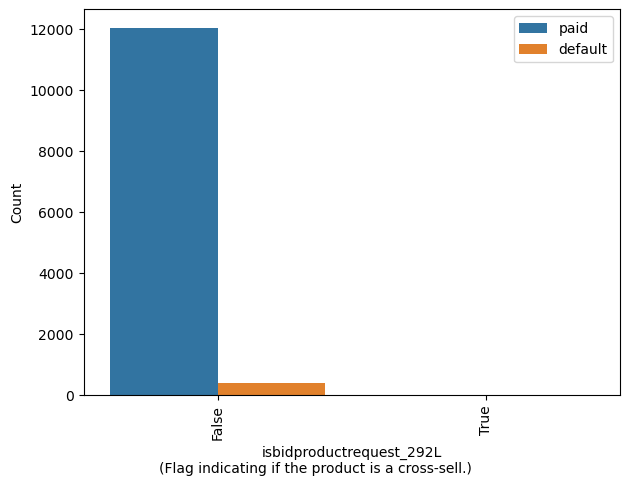

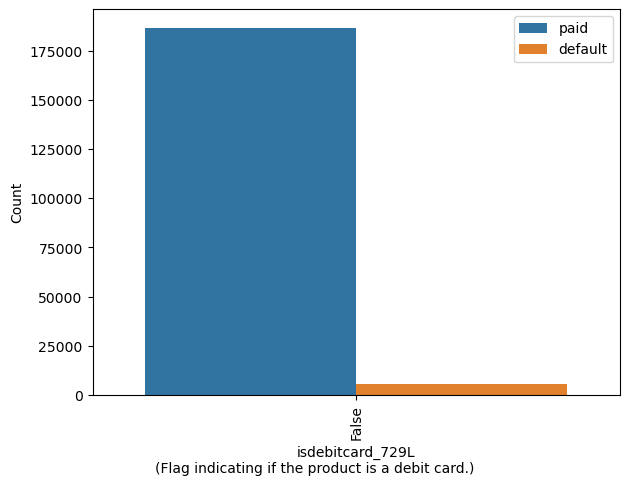

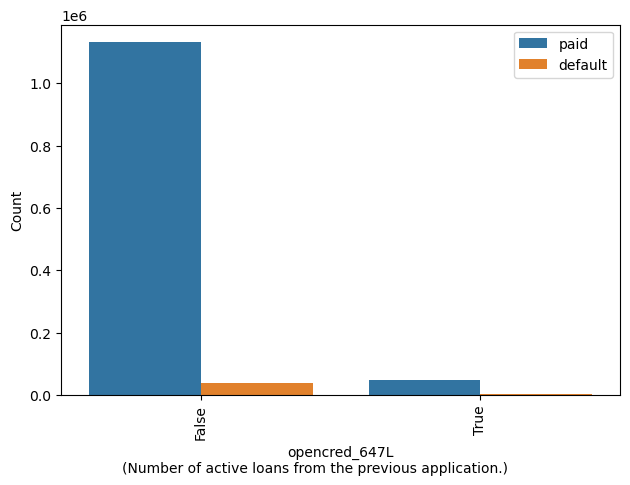

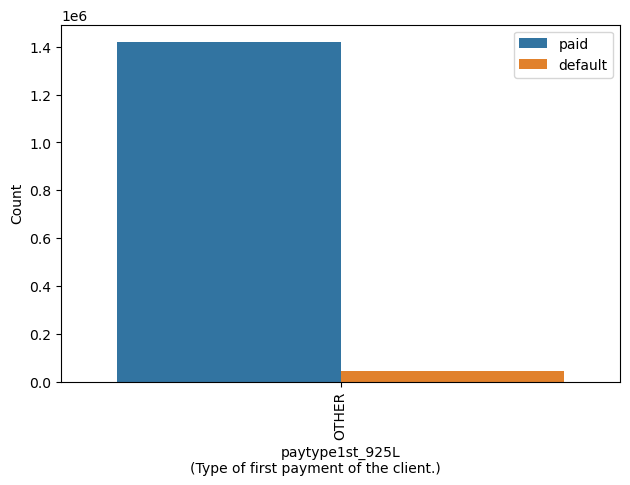

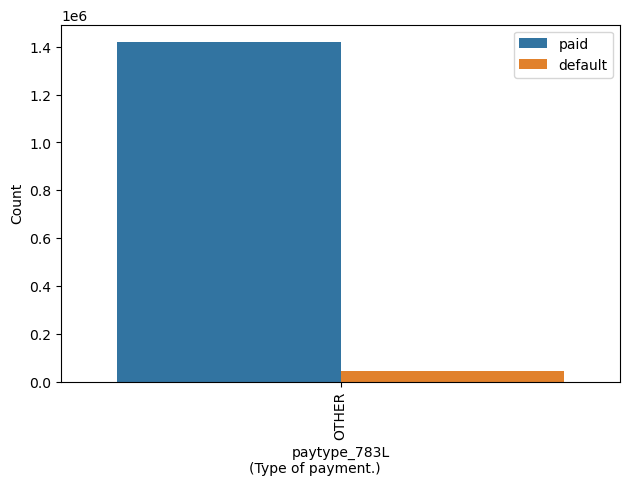

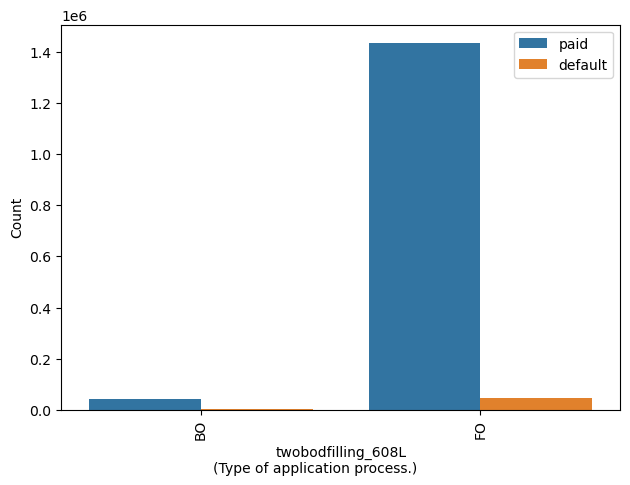

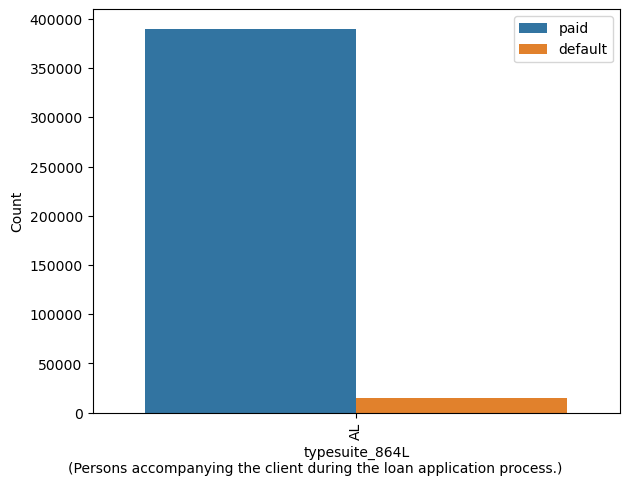

In [44]:
for i in short_features_cat:
    print(i)
    plot_categorical(train_static_internal_pd, i, f'({dict_feature[i]})')

## CONCLUSIONS

For this dataframe we can conclude that on a first glance, the internal dataset has a good quality.

We only have to take into account that:

- The NAs seem informative and so we don't have to drop them. 
- We don't know nothing about the outlier values at the moment. Maybe they are informative so we will not drop them.
- the date can be used to compute a time difference. 